In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 53 kB/s 


In [2]:
import os
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from mpl_toolkits.mplot3d import Axes3D
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *

# EDA

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [6]:
train_df = pd.read_csv('credit_scoring_train.csv', delimiter=',')
train_df.dataframeName = 'credit_scoring_train.csv'
train_df.drop('client_id', axis=1, inplace=True)
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns')

There are 75000 rows and 10 columns


In [7]:
test_df = pd.read_csv('credit_scoring_test.csv', delimiter=',')
test_df.dataframeName = 'credit_scoring_test.csv'
test_df.drop('client_id', axis=1, inplace=True)
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns')

There are 75000 rows and 9 columns


In [25]:
train_df.head(5)

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90,NumRealEstateLoans_per_NumLoans,NumRealEstateLoans_per_NumDependents,NumRealEstateLoans_per_Num30-59Delinquencies,NumRealEstateLoans_per_Num60-89Delinquencies,NumDependents_per_NumLoans,Num30-59Delinquencies_per_NumLoans,Num60-89Delinquencies_per_NumLoans,age_group
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0,0.000000,0.0,0.0,0.0,0.000000,0.153846,0.0,3
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0,0.222222,1.0,2.0,0.0,0.222222,0.111111,0.0,3
2,2206.731199,55.5,21,1,0.0,1,0,5424.552473,0.348227,0,0.047619,0.0,1.0,0.0,0.000000,0.047619,0.0,3
3,886.132793,55.3,3,0,0.0,0,0,5424.552473,0.971930,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,3
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,3


In [9]:
train_df.Delinquent90.value_counts(normalize=True)

0    0.93316
1    0.06684
Name: Delinquent90, dtype: float64

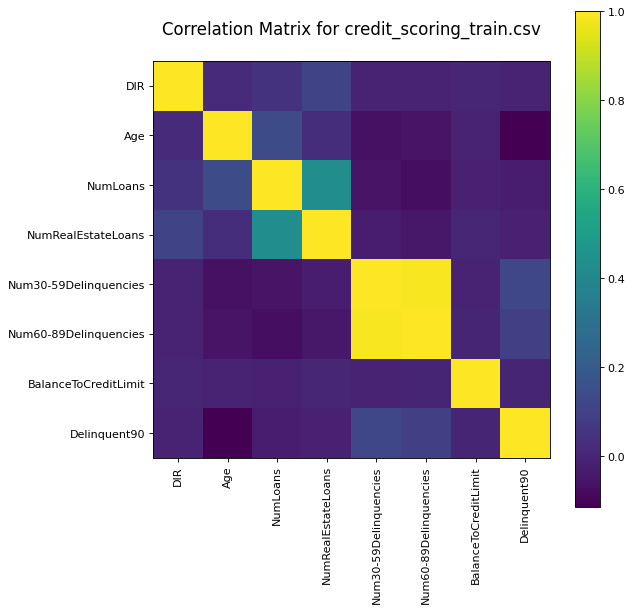

In [10]:
plotCorrelationMatrix(train_df, 8)

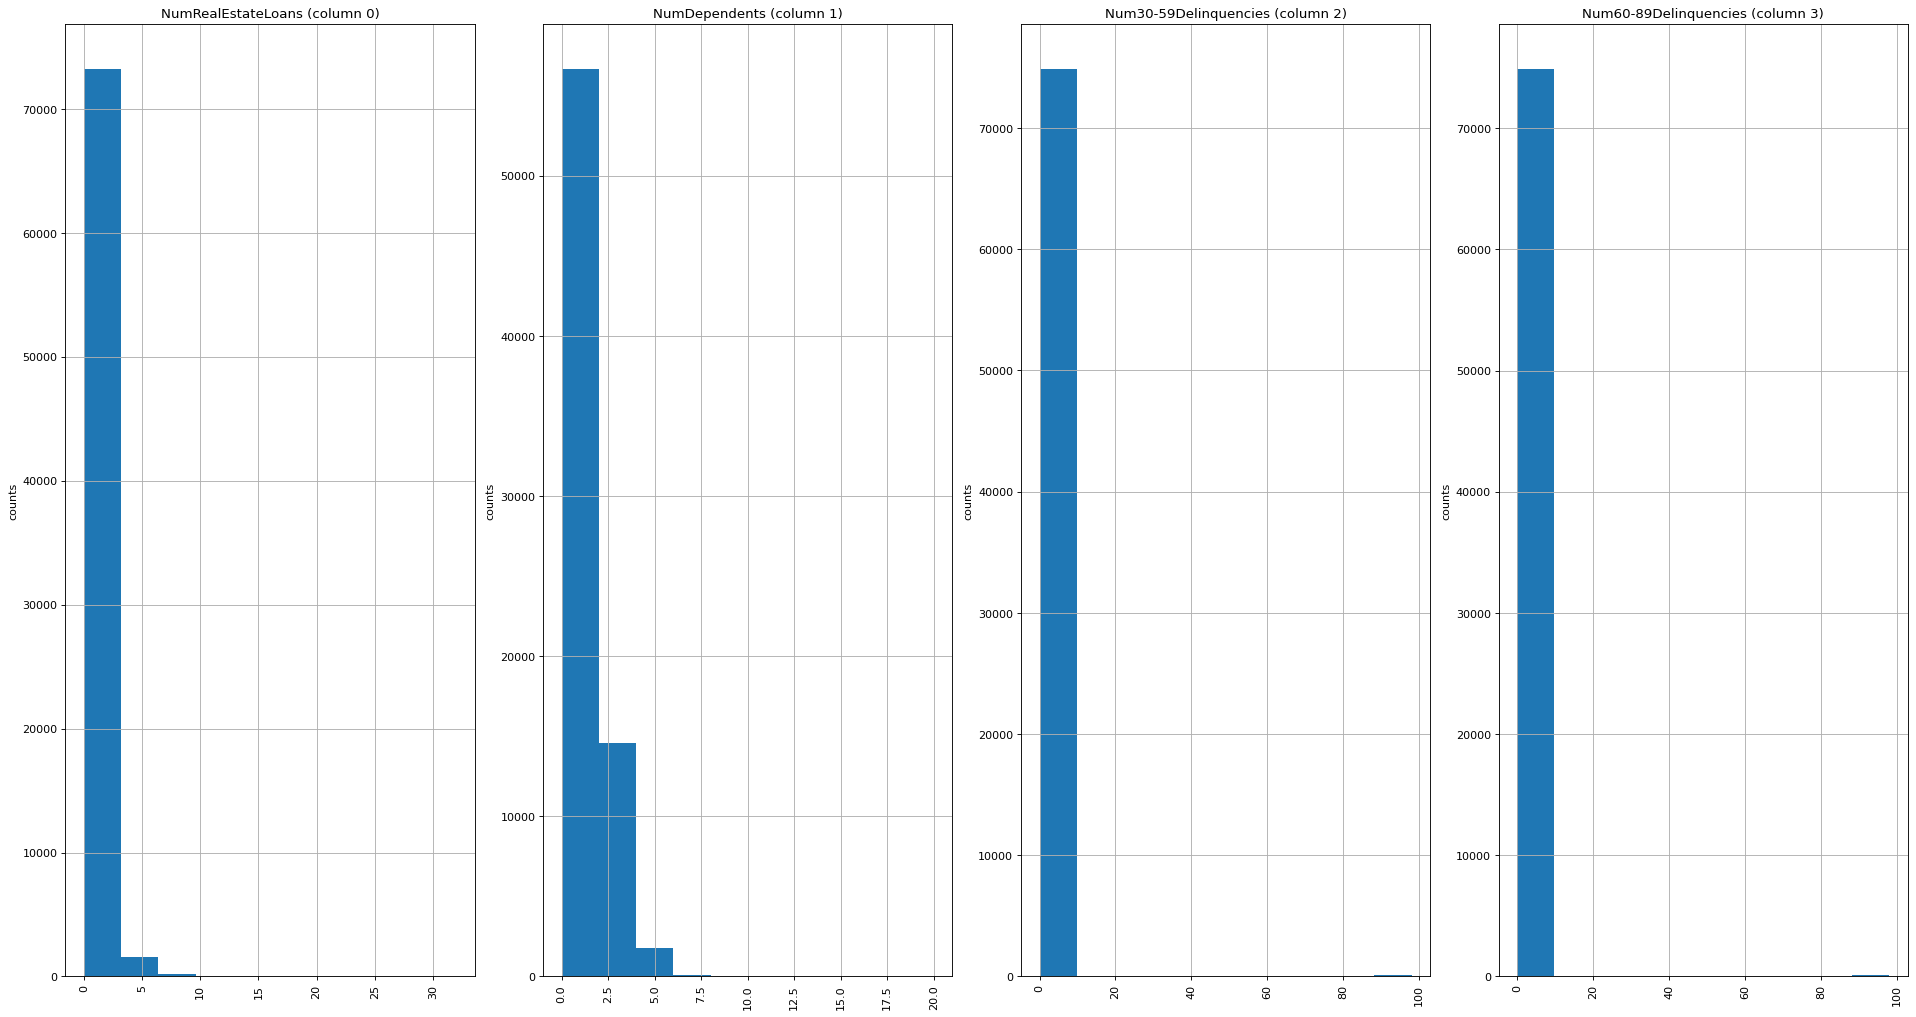

In [11]:
plotPerColumnDistribution(train_df.drop('Delinquent90', axis=1), 5, 5)

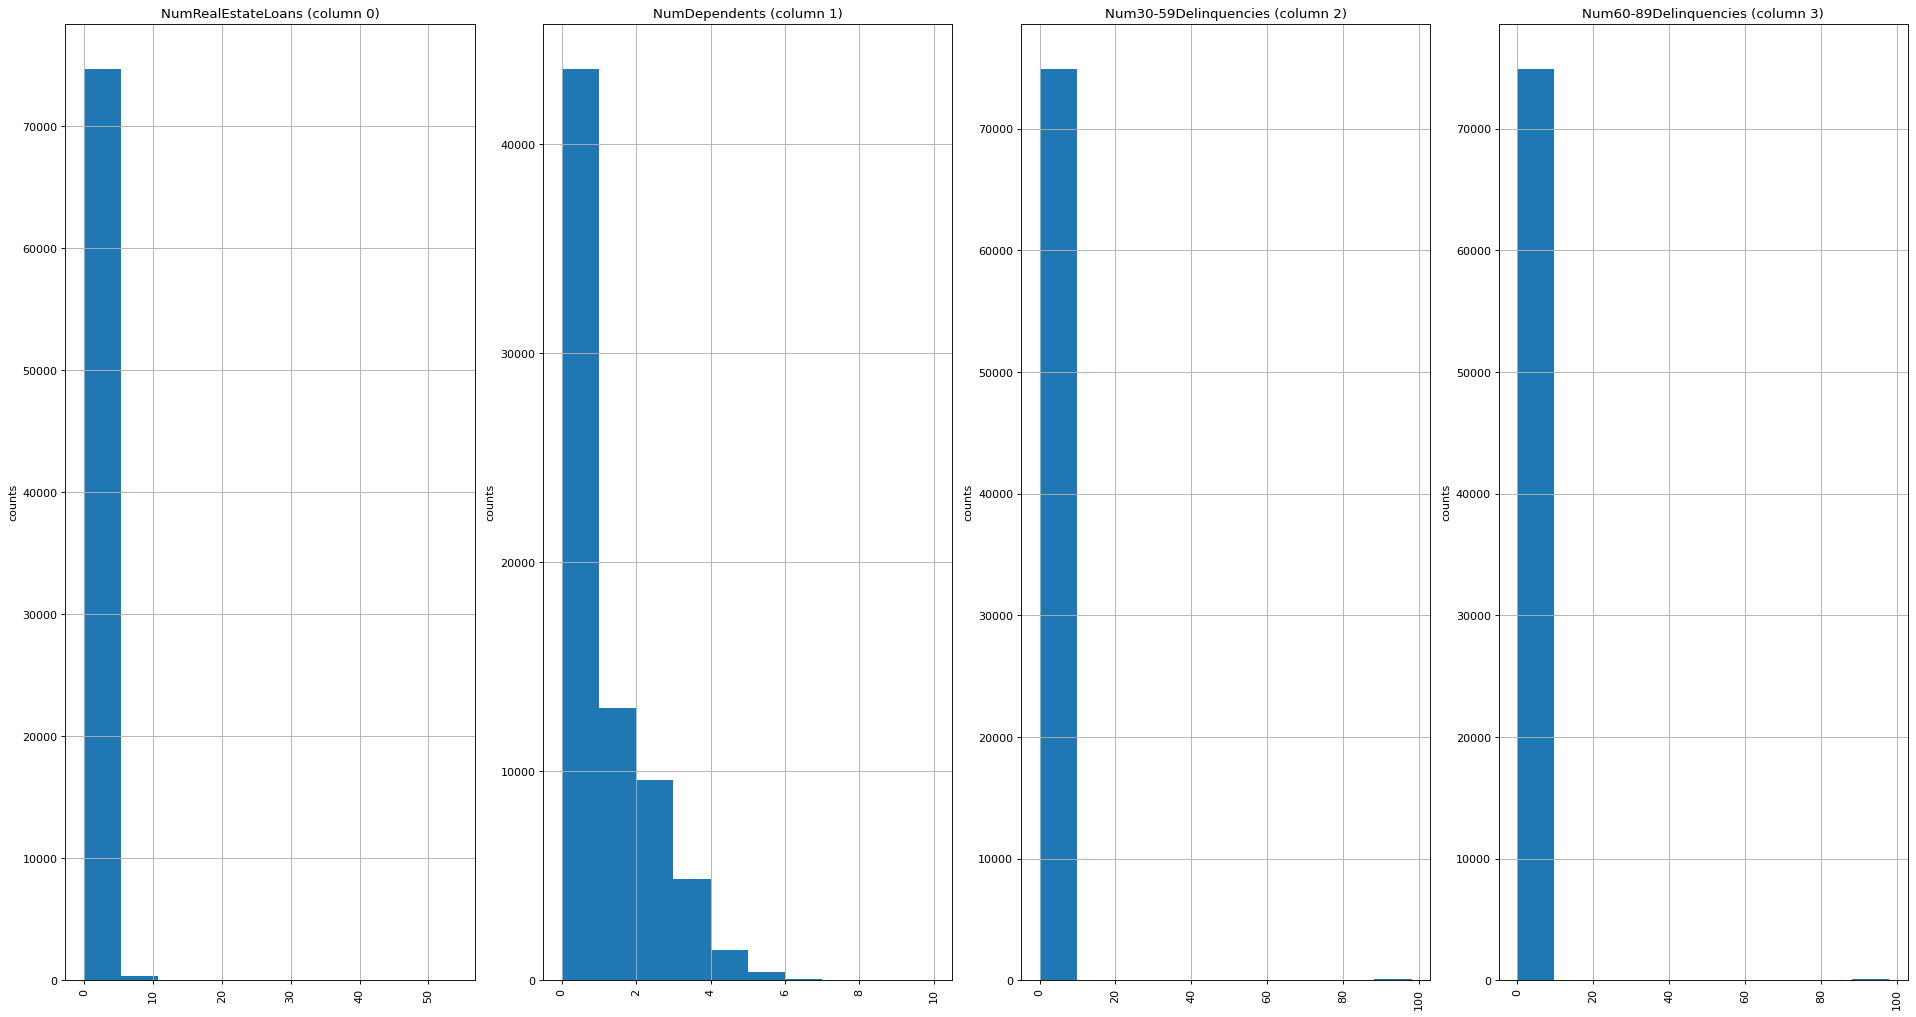

In [12]:
plotPerColumnDistribution(test_df, 5, 5)

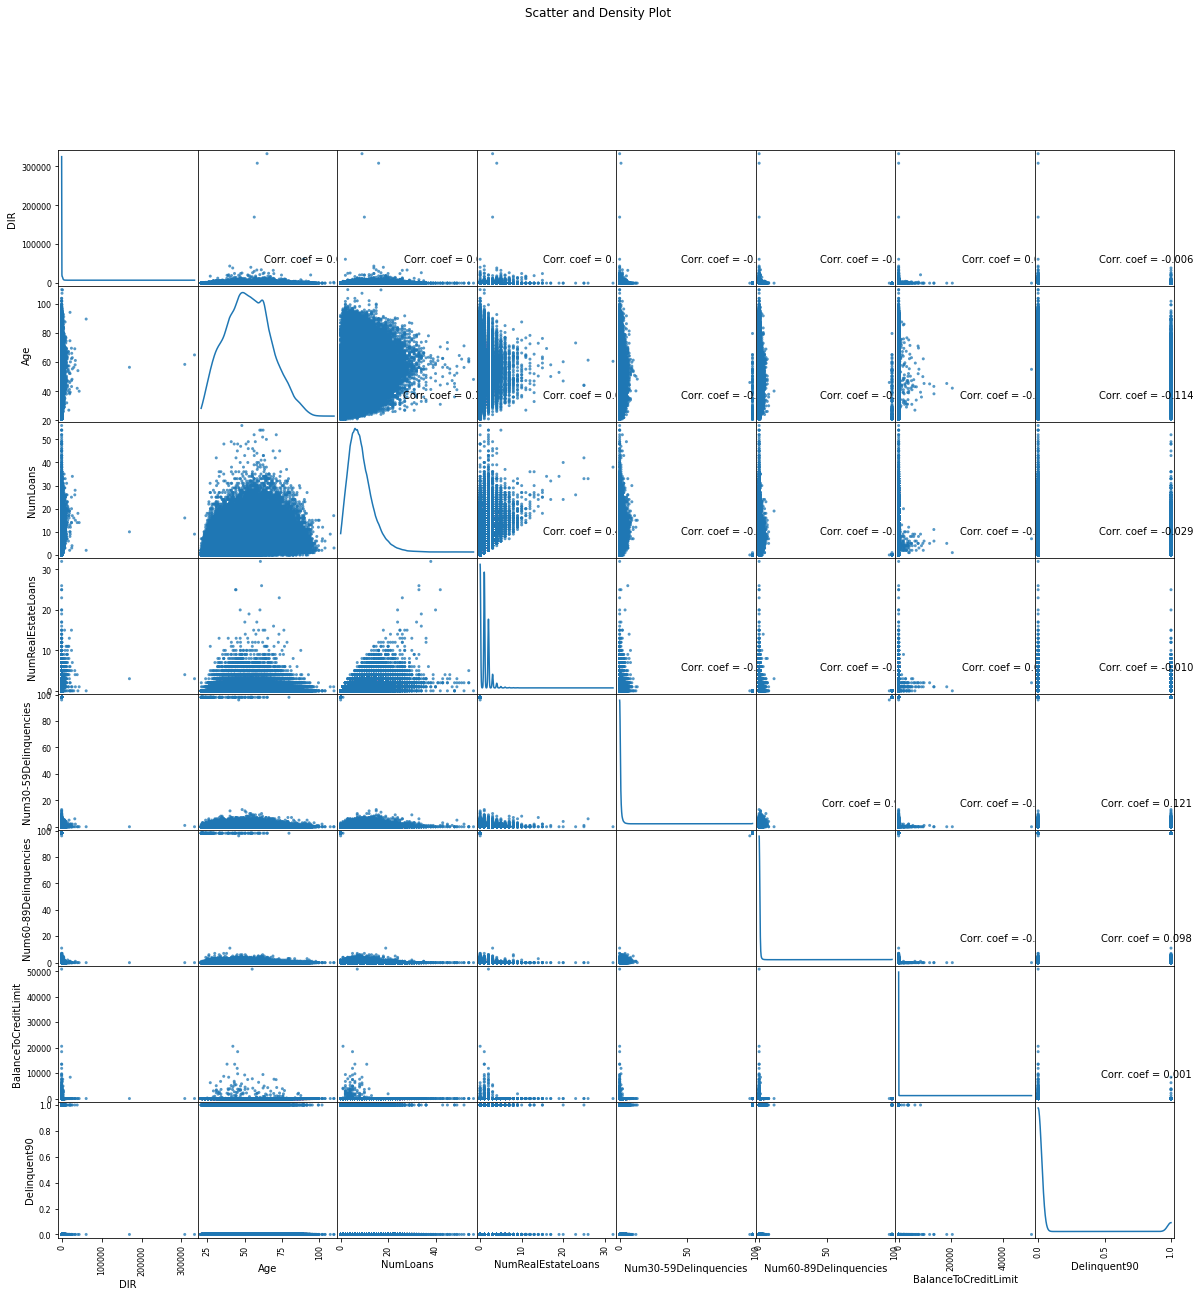

In [13]:
plotScatterMatrix(train_df, 20, 10)

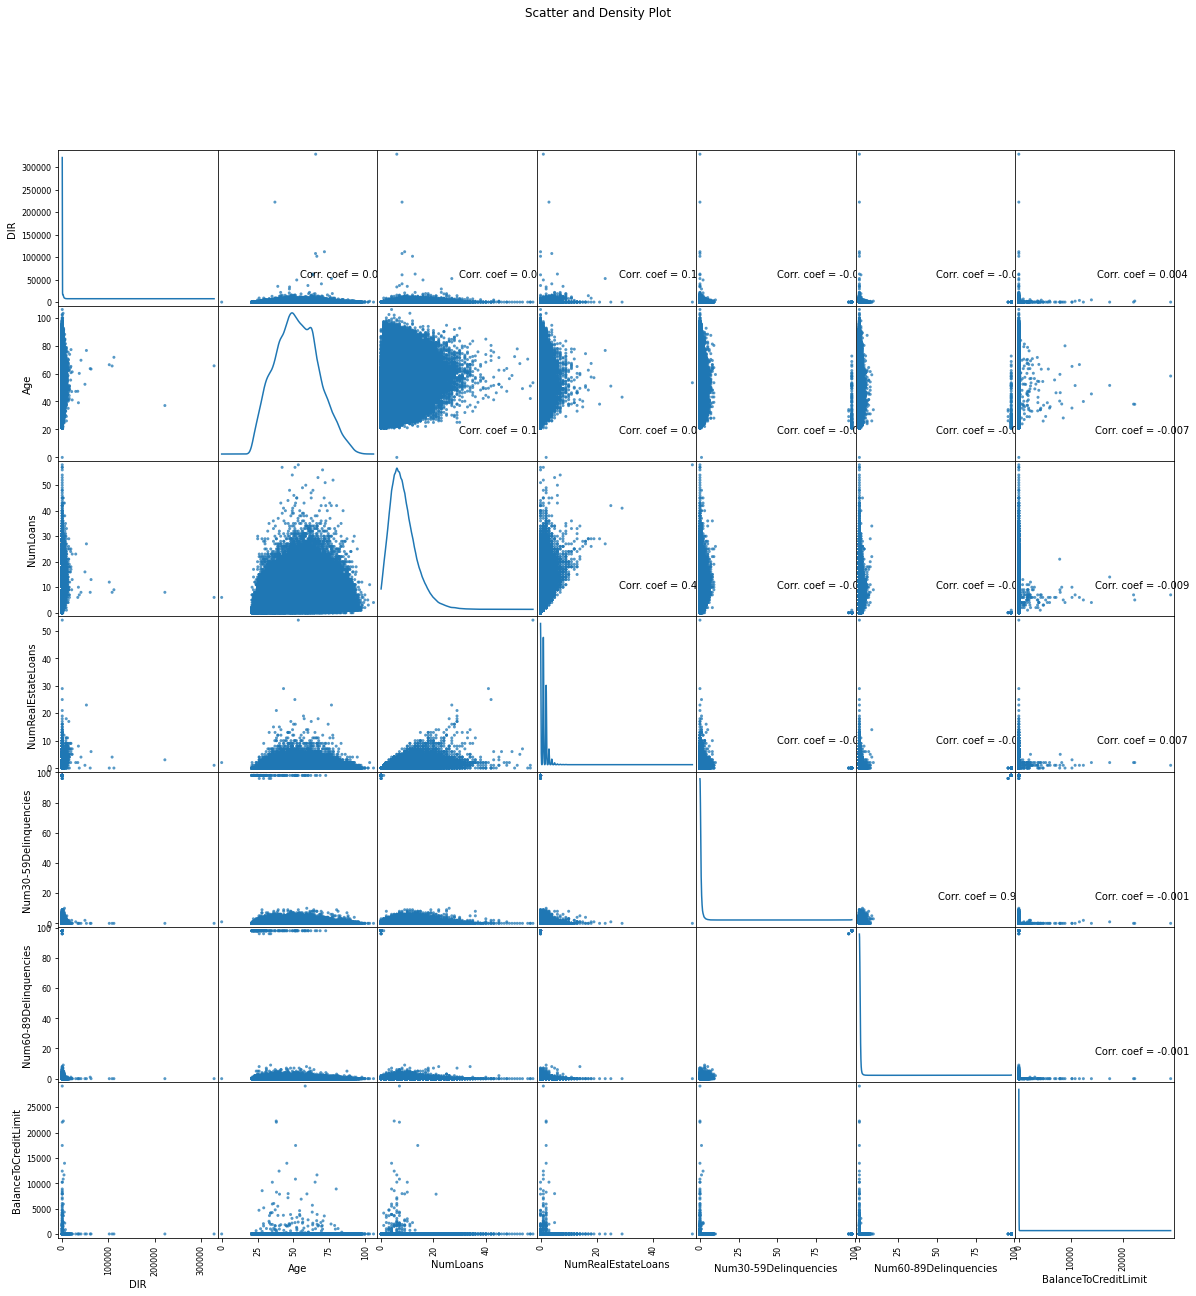

In [14]:
plotScatterMatrix(test_df, 20, 10)

# Feature enginering

Признаки клиентов банка:

Age - возраст (вещественный)

Income - месячный доход (вещественный)

BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)

DIR - Debt-to-income Ratio (вещественный)

NumLoans - число заемов и кредитных линий

NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)

NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)

Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней 
(натуральное число)

Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)

Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

## Посмотрим кол-во пропущенных значений

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          73084 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 60153 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
 9   Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 5.7 MB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          72992 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 60116 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 5.1 MB


In [17]:
train_df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
count,75000.000000,75000.000000,75000.00000,75000.000000,73084.000000,75000.000000,75000.000000,6.015300e+04,75000.000000,75000.000000
mean,353.260293,52.595605,8.44976,1.016693,0.755966,0.428320,0.248000,6.740059e+03,6.276196,0.066840
std,2117.237432,14.869729,5.15644,1.124019,1.108119,4.276439,4.239486,1.422875e+04,267.743321,0.249746
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.176022,41.300000,5.00000,0.000000,0.000000,0.000000,0.000000,3.421354e+03,0.029703,0.000000
50%,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,5.424552e+03,0.153720,0.000000
75%,0.862650,63.100000,11.00000,2.000000,1.000000,0.000000,0.000000,8.291518e+03,0.560638,0.000000
max,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533,1.000000


In [18]:
test_df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
count,75000.000000,75000.000000,75000.000000,75000.000000,72992.000000,75000.000000,75000.000000,6.011600e+04,75000.000000
mean,356.329252,52.515599,8.455760,1.019787,0.758480,0.413747,0.232773,6.667196e+03,5.874272
std,1981.415521,14.823871,5.135473,1.135499,1.122025,4.107435,4.069140,1.470689e+04,232.390228
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.175984,41.300000,5.000000,0.000000,0.000000,0.000000,0.000000,3.410792e+03,0.030401
50%,0.369472,52.100000,8.000000,1.000000,0.000000,0.000000,0.000000,5.421111e+03,0.156201
75%,0.882949,63.100000,11.000000,2.000000,1.000000,0.000000,0.000000,8.271528e+03,0.562832
max,328691.817648,105.800000,58.000000,54.000000,10.000000,98.000000,98.000000,3.027514e+06,29182.981935


In [19]:
# В тесте и в трейне пропущены значения в столбцах Income и NumDependents, заполним данные столбцы медианными значениями
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)

test_df['NumDependents'].fillna(test_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), inplace=True)

# Минимальный возраст в трейне 21, а в тесте 0, заполним минимальным возможным значением
train_df.loc[train_df['Age'] < 21, 'Age'] = 21
test_df.loc[test_df['Age'] < 21, 'Age'] = 21

## Добавим признаки

In [20]:
def get_dif_features(row, left_feat, right_feat):
    '''Построение отношения между признаками'''
    if row[right_feat] == 0:
        return 0
    else:
        return row[left_feat] / row[right_feat]


# Добавим признаки отношения числа ипотек/заемов к другим 'NumLoans', 'NumDependents', 'Num30-59Delinquencies', 'Num60-89Delinquencies'
for right_feat in ['NumLoans', 'NumDependents', 'Num30-59Delinquencies', 'Num60-89Delinquencies']:
    left_feat = 'NumRealEstateLoans'
    train_df[f'{left_feat}_per_{right_feat}'] = train_df.apply(lambda x: get_dif_features(x, left_feat, right_feat), axis=1)
    test_df[f'{left_feat}_per_{right_feat}'] = test_df.apply(lambda x: get_dif_features(x, left_feat, right_feat), axis=1)

# Добавим признаки отношения признаков 'NumDependents', 'Num30-59Delinquencies', 'Num60-89Delinquencies' к числу всех заемов
for left_feat in ['NumDependents', 'Num30-59Delinquencies', 'Num60-89Delinquencies']:
    right_feat = 'NumLoans'
    train_df[f'{left_feat}_per_{right_feat}'] = train_df.apply(lambda x: get_dif_features(x, left_feat, right_feat), axis=1)
    test_df[f'{left_feat}_per_{right_feat}'] = test_df.apply(lambda x: get_dif_features(x, left_feat, right_feat), axis=1)

# Добавим признак по возрастной группе
age_groups = [0, 20, 30, 45, 60, 150]
labels = [i for i in range(len(age_groups) - 1)]
train_df['age_group'] = pd.cut(train_df['Age'], bins=age_groups, right=False, labels=labels).astype(int)
test_df['age_group'] = pd.cut(test_df['Age'], bins=age_groups, right=False, labels=labels).astype(int)

# Построим модели машинного обучения

In [21]:
# Разделим данные на трейн, валид и тест в соотношении [0.6, 0.2, 0.2]
target = 'Delinquent90'
x, y = train_df.drop(target, axis=1), train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=X_valid.shape[0], shuffle=y, random_state=42)
# Размеры обучающей, валидационной и тестовой выборок
X_train.shape, X_valid.shape, X_test.shape

((45000, 17), (15000, 17), (15000, 17))

In [22]:
# словарь для записи предобученных моделей и их скоринга
models = {}

In [23]:
def check_metrics(model, x, y):
    '''Функция построения графиков'''
    y_pred = model.predict(x)
    print(classification_report(y.values.reshape(-1, 1), y_pred.reshape(-1, 1)))
    plot_roc_curve(model,x, y)
    plot_precision_recall_curve(model, x, y)

    # Посчитаем gini, как основную, часто используемую метрику
    roc_auc = roc_auc_score(y, model.predict_proba(x)[:, 1])
    return 2 * roc_auc - 1

## XGBoost

[0]	validation_0-auc:0.791215
Will train until validation_0-auc hasn't improved in 10 rounds.
[50]	validation_0-auc:0.821902
[100]	validation_0-auc:0.833185
[150]	validation_0-auc:0.84172
[200]	validation_0-auc:0.844485
[250]	validation_0-auc:0.845869
[300]	validation_0-auc:0.846924
[350]	validation_0-auc:0.847734
Stopping. Best iteration:
[355]	validation_0-auc:0.847826

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     13982
           1       0.60      0.12      0.20      1018

    accuracy                           0.93     15000
   macro avg       0.77      0.56      0.58     15000
weighted avg       0.92      0.93      0.91     15000



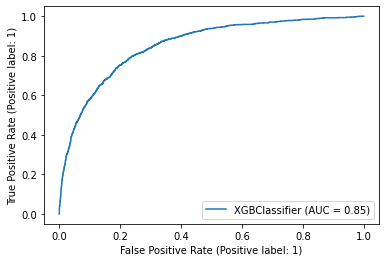

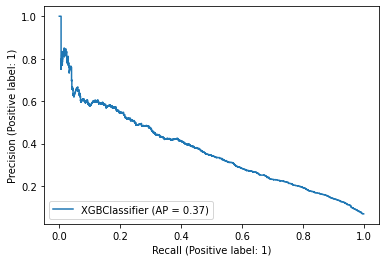

In [24]:
xgb_model = XGBClassifier(
    n_estimators= 500,
    objective = "binary:logistic",
    learning_rate= 0.03,
    seed = 13
)
xgb_model.fit(X_train, y_train, eval_set=[[X_valid, y_valid]], verbose=50, eval_metric=['auc'], early_stopping_rounds=10)
models['xgb_model'] = check_metrics(xgb_model, X_test, y_test)

## CatBoost

0:	learn: 0.6514538	test: 0.6512871	best: 0.6512871 (0)	total: 62.2ms	remaining: 31s
50:	learn: 0.2038254	test: 0.1996735	best: 0.1996735 (50)	total: 815ms	remaining: 7.18s
100:	learn: 0.1880313	test: 0.1852439	best: 0.1852439 (100)	total: 1.59s	remaining: 6.28s
150:	learn: 0.1847846	test: 0.1834682	best: 0.1834682 (150)	total: 2.33s	remaining: 5.38s
200:	learn: 0.1827743	test: 0.1829231	best: 0.1829183 (194)	total: 3.07s	remaining: 4.57s
250:	learn: 0.1810338	test: 0.1825076	best: 0.1825076 (250)	total: 3.81s	remaining: 3.78s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1824304337
bestIteration = 265

Shrink model to first 266 iterations.
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     13982
           1       0.59      0.12      0.20      1018

    accuracy                           0.93     15000
   macro avg       0.76      0.56      0.58     15000
weighted avg       0.92      0.93      0.91     15000



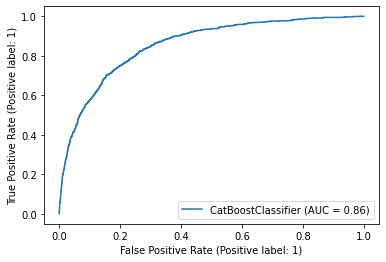

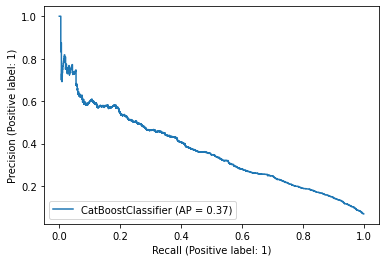

In [ ]:
cat_model = CatBoostClassifier(
    n_estimators = 500,
    loss_function = "Logloss",
    learning_rate = 0.03,
    random_seed = 13,
)
cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=50, early_stopping_rounds=10)
models['cat_model'] = check_metrics(cat_model, X_test, y_test)

## LGBM

Training until validation scores don't improve for 10 rounds.
[50]	valid_0's binary_logloss: 0.186873
[100]	valid_0's binary_logloss: 0.183015
[150]	valid_0's binary_logloss: 0.182608
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.182539
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     13982
           1       0.59      0.12      0.20      1018

    accuracy                           0.93     15000
   macro avg       0.76      0.56      0.58     15000
weighted avg       0.92      0.93      0.91     15000



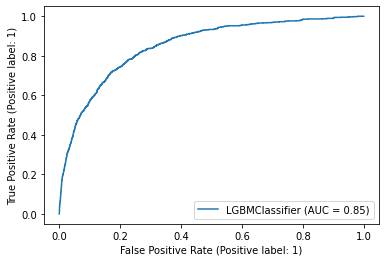

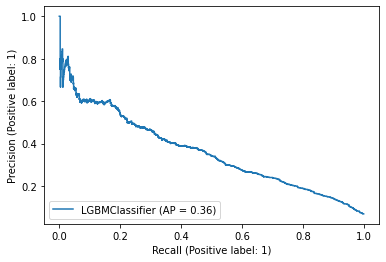

In [ ]:
lgbm_model = LGBMClassifier(
    n_estimators = 500,
    objective = 'binary',
    max_depth = 6,
    learning_rate = 0.03,
    seed = 13
)
lgbm_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=50, early_stopping_rounds=10)
models['lgbm_model'] = check_metrics(lgbm_model, X_test, y_test)

# Выбор модели

In [ ]:
models

{'cat_model': 0.7121997156602413,
 'lgbm_model': 0.703225716252077,
 'xgb_model': 0.7080013624027974}

In [ ]:
best_model, best_metric = max(models.items(), key=lambda x: x[1])
print(f'Best model: {best_model}, \nBest metric GINI: {best_metric}')

Best model: cat_model, 
Best metric GINI: 0.7121997156602413


In [ ]:
test_df['score'] = cat_model.predict(test_df)

In [ ]:
test_df.head(5)

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,NumRealEstateLoans_per_NumLoans,NumRealEstateLoans_per_NumDependents,NumRealEstateLoans_per_Num30-59Delinquencies,NumRealEstateLoans_per_Num60-89Delinquencies,NumDependents_per_NumLoans,Num30-59Delinquencies_per_NumLoans,Num60-89Delinquencies_per_NumLoans,age_group,score
0,0.488558,39.2,7,2,2.0,0,0,2866.926559,0.369443,0.285714,1.0,0.0,0.0,0.285714,0.0,0.0,2,0
1,0.132810,42.3,8,0,1.0,4,0,4303.412944,1.028329,0.000000,0.0,0.0,0.0,0.125000,0.5,0.0,2,1
2,1784.812905,51.5,5,1,0.0,0,0,5421.111494,0.081461,0.200000,0.0,0.0,0.0,0.000000,0.0,0.0,3,0
3,0.538571,57.1,30,2,0.0,0,0,7672.294930,0.485850,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,3,0
4,0.098539,70.1,3,0,0.0,0,0,4507.010360,0.004258,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,4,0


Так как данные табличные, то было построено три модели деревьев: xgboost, catboost, lightgbm. По выбранной метрике оказалась лучшей модель catboost. Качество предсказание низкое, но добавив дополнительные признаки и данные, думаю его можно улучшить.

В качестве метрики оценки точности моделей была выбрана метрика GINI, т.к. она используется чаще всего в банковской сфере для оценки стабильности и качества моделей, также можно использовать метрику precision для увеличения количества правильных предсказаний, но тогда необходимо также итерационно подбирать treshold. 